<a href="https://colab.research.google.com/github/atlantiquesun/Stock_ML/blob/main/full_test_run_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas as pd
import requests
from sklearn import preprocessing
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
from copy import deepcopy

# Setting
In this test run:

*   **number of companies**: 46
*   **training start month**: 2010-01-01
*   **training window size**: 24 months
*   **validation window size**: 4 months
*   **trade start month**: 2012-05-01
*   **trade end month**: 2021-03-01




---


Some problems/questions

*   Cumulative return varies a lot depending on models (some models perform better than the baseline, which assigns each ticker an equal weight, while some models perform worse).
*   monthly return prediction is not accurate (see the prediction for a sample stock in Section 5.Other Visualisation). In particular, predicted return seems to have a much smaller magnitude than the actual return.












# 1. Calculate Cumulative Data 

In [ ]:

#calculate the daily cumulative for each company
def calculate_cumulative(start=0, end=82, excludes = []):
  '''
  start: start company (index 0 to 81)
  end: end company (the last company to be processed)
  last end: 3 (elastic is not processed)
  '''
  companies = pd.read_csv("/content/drive/MyDrive/StockML /Data/companyInfo/companies_final.csv")
  dataCategories = []
  for name in os.listdir("/content/drive/MyDrive/StockML /Data/"):
    if "History" in name: #if is a part of the raw data
      dataCategories.append(name)

  for i in range(companies.shape[0]):
    if (i < start):continue

    company = companies.at[i, 'githubUser']
    if (company in excludes):continue

    normalizedName = companies.at[i, "shortName"]
    print(company, normalizedName)
    cumulativeData = {}
    cumulativeData["date"] = list(pd.date_range(start="1/01/1999", end='9/01/2021').tz_localize(None)) #need to check the timezone
    
    #calculate the cumulative data for each category
    for category in dataCategories:
      df = pd.read_csv("/content/drive/MyDrive/StockML /Data/"+category+"/"+company+".csv")
      df["sum"] = df.sum(axis=1) #sum over the repositories
      cumulativeData[category[:-7]] = list(df["sum"])
    

    cumulativeData = pd.DataFrame(cumulativeData)

    #select only the github data after the date of creation
    response = requests.get("https://api.github.com/users/"+company)
    created_at = pd.to_datetime(response.json()['created_at']).tz_localize(None)
    cumulativeData = cumulativeData.loc[cumulativeData["date"] >= created_at]

    cumulativeData.to_csv("/content/drive/MyDrive/StockML /Data/processedData/cumulativeData/"+company+".csv")

    if(i==end): break

calculate_cumulative(start=0, end=52, excludes = ["digitalocean", "alibaba", "bigcommerce", "microsoft", "westerndigitalcorporation", "cargurus"])

# 2. Prepare Non-series Data

In [58]:
def prepare_full_data(last_company_index,  start_month, end_month, features_column, lag, excludes=[]):
  '''
  cluster into months, concatenate github and stock data
  '''
  df_complete = None
  companies = pd.read_csv("/content/drive/MyDrive/StockML /Data/companyInfo/companies_final.csv")
  start_month = pd.to_datetime(start_month)
  end_month = pd.to_datetime(end_month)

  for i in range(companies.shape[0]):
    company = companies.at[i, 'githubUser']
    if (company in excludes):continue

    ticker = companies.at[i, 'symbol'].upper()
    print(company)

    raw = pd.read_csv("/content/drive/MyDrive/StockML /Data/processedData/cumulativeData/"+company+".csv")
    raw = raw.drop('Unnamed: 0', axis=1)
    raw.date = pd.to_datetime(raw['date'])

    #filter the companies who do not have enough star data
    if(np.asarray(raw['star']).sum() < 1000):
      continue

    #group GitHub data into months
    df = raw.groupby(pd.Grouper(key="date", freq="M")).sum()
    df['month_end'] = df.index
    month_starts = [x+datetime.timedelta(days=1)-relativedelta(months=1) for x in list(df['month_end'])]
    df['month_start'] = month_starts
    df.index = df.month_start

    #select the months within the window
    df = df.loc[(df['month_start'] >= start_month) & (df['month_start'] <= end_month)]
    scaler = MinMaxScaler()
    df[features_column] = scaler.fit_transform(df[features_column])
    df[features_column] = df[features_column].shift(lag)
    df = df.dropna() #lag GitHub data

    #group stock data into months then select the last datum in a month to calculate monthly return
    stock_data = pd.read_csv("/content/drive/MyDrive/StockML /Data/financialData/"+ticker+".csv")
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.groupby(pd.Grouper(key="Date", freq="M")).nth([-1]) #currently indices are month-ends
    stock_data['Date'] = [x + relativedelta(days=1) - relativedelta(months=1) for x in list(stock_data.index)]
    stock_data.index = stock_data.Date #now indices are month-starts
    stock_data['last_close'] = stock_data['Adj Close'].shift(1)
    stock_data['monthly_return'] = (stock_data['Adj Close'] / stock_data['last_close'])-1
    #stock_data['monthly_return'] = stock_data.monthly_return.shift(-lag) #lag the GitHub data
    stock_data = stock_data.dropna()

    #select the months within the window
    stock_df = stock_data.loc[(stock_data['Date'] >= start_month) & (stock_data['Date'] <= end_month)]

    #concatenate GitHub and stock data
    df = df.loc[df['month_start'].isin(list(stock_df['Date']))]
    stock_df = stock_df.loc[stock_df['Date'].isin(list(df['month_start']))]
    df['monthly_return'] = stock_df["monthly_return"].values
    print(df.shape)

    df.to_csv("/content/drive/MyDrive/StockML /Data/trainData/companies/"+company+".csv")
    
    df['ticker'] = ticker

    #concatenate companies' data
    if (df_complete is None):
      df_complete = df
    else:
      df_complete = pd.concat([df_complete, df])
    
    if i == last_company_index: break

  return df_complete

In [27]:
def get_daily_return(start_date, end_date):

  start_date = pd.to_datetime(start_date)
  end_date = pd.to_datetime(end_date) 

  tickers = os.listdir("/content/drive/MyDrive/StockML /Data/financialData")
  tickers = [t.split('.')[0] for t in tickers]

  dates = pd.date_range(start=start_date, end=end_date)
  daily_return = pd.DataFrame(index = dates, columns = ["TOBEREMOVED"])

  for ticker in tickers:
    df = pd.read_csv("/content/drive/MyDrive/StockML /Data/financialData/"+ticker+".csv")
    df.index = pd.to_datetime(df.Date)
    closeadj = df['Adj Close'].fillna(method='ffill').fillna(method='bfill')
    closeadj = closeadj.to_frame(name=ticker)
    df = (closeadj-closeadj.shift(1))/closeadj.shift(1)
    df = df.loc[df.index>=start_date]
    daily_return = pd.concat([daily_return, df], axis = 1)

  daily_return = daily_return.dropna(axis=0, how='all')
  daily_return = daily_return.dropna(axis=1, how='all')
  #daily_return = daily_return.fillna(0)

  return daily_return


In [89]:
def get_monthly_return(start_month, end_month):

  start_month = "2010-01-01"
  end_month = "2021-03-01"
  start_month = pd.to_datetime(start_month)
  end_month = pd.to_datetime(end_month)

  tickers = os.listdir("/content/drive/MyDrive/StockML /Data/financialData")
  tickers = [t.split('.')[0] for t in tickers]

  months = pd.date_range(start=start_month, end=end_month, freq='MS')
  monthly_return = pd.DataFrame(index=months, columns = ["TOBEREMOVED"])

  for ticker in tickers:
    df = pd.read_csv("/content/drive/MyDrive/StockML /Data/financialData/"+ticker+".csv")
    df.Date = pd.to_datetime(df.Date)
    df = df.groupby(pd.Grouper(key="Date", freq="M")).nth([-1])
    df.index = [x + relativedelta(days=1)-relativedelta(months=1) for x in list(df.index)]
    closeadj = df['Adj Close']
    closeadj = closeadj.to_frame(name=ticker)
    df = (closeadj-closeadj.shift(1))/closeadj.shift(1)
    df = df.loc[df.index>=start_month]
    df = df.loc[df.index<=end_month]
    monthly_return = pd.concat([monthly_return, df], axis = 1)

  monthly_return = monthly_return.dropna(axis=0, how='all')
  monthly_return = monthly_return.dropna(axis=1, how='all')
  #monthly_return = monthly_return.fillna(0)

  return monthly_return

# 3. Models

New Models

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


def train_linear_regression(X_train,y_train):

    lr_regressor = LinearRegression()
    model = lr_regressor.fit(X_train, y_train)
    
    return model


def train_recursive_feature_elimination(X_train,y_train):

    lr_regressor = LinearRegression(random_state = 42)
    model = RFE(lr_regressor)
    
    return model



def train_lasso(X_train, y_train):
    # lasso_regressor = Lasso()
    # model = lasso_regressor.fit(X_train, y_train)

    lasso = Lasso()
    # scoring_method = 'r2'
    # scoring_method = 'explained_variance'
    scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'
    parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
    # my_cv_lasso = TimeSeriesSplit(n_splits=3).split(X_train_advanced)
    lasso_regressor = GridSearchCV(lasso, parameters, scoring=scoring_method, cv=3)
    lasso_regressor.fit(X_train, y_train)

    model = lasso_regressor.best_estimator_
    return model



def train_ridge(X_train, y_train):
    # lasso_regressor = Lasso()
    # model = lasso_regressor.fit(X_train, y_train)

    ridge = Ridge()
    # scoring_method = 'r2'
    # scoring_method = 'explained_variance'
    scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'
    parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
    # my_cv_lasso = TimeSeriesSplit(n_splits=3).split(X_train_advanced)
    ridge_regressor = GridSearchCV(ridge, parameters, scoring=scoring_method, cv=3)
    ridge_regressor.fit(X_train, y_train)

    model = ridge_regressor.best_estimator_
    return model



def train_random_forest(X_train, y_train):
    '''
    random_grid = {'bootstrap': [True, False],
                   'max_depth': [10, 20, 40, 80, 100, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [50, 200, 400, 600, 800, 1000, 1500]}
    # my_cv_rf = TimeSeriesSplit(n_splits=5).split(X_train_rf)
    rf = RandomForestRegressor(random_state=42)
    randomforest_regressor = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                                cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=0)
    randomforest_regressor.fit(X_train, y_train)
    model = randomforest_regressor.best_estimator_
    '''
    randomforest_regressor = RandomForestRegressor(n_estimators = 500, max_features=6)
    #randomforest_regressor = RandomForestRegressor(random_state = 42,n_estimators = 300)

    model = randomforest_regressor.fit(X_train, y_train)
    
    return model




def train_svm(X_train, y_train):
    svr = SVR(kernel = 'rbf')

    param_grid_svm = {'C':[0.001, 0.01, 0.1, 1, 10],'gamma': [1e-7, 1e-4,0.001,0.1]}
    #param_grid_svm = {'kernel': ('linear', 'rbf','poly'), 'C':[0.001, 0.01, 0.1, 1, 10],'gamma': [1e-7, 1e-4,0.001,0.1],'epsilon':[0.1,0.2,0.5,0.3]}

    # scoring_method = 'r2'
    # scoring_method = 'explained_variance'
    scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'
    
    svm_regressor = GridSearchCV(estimator=svr, param_grid=param_grid_svm,
                                       cv=3, n_jobs=-1, scoring=scoring_method, verbose=0)

    svm_regressor.fit(X_train, y_train)
    model = svm_regressor.best_estimator_

    return model



def train_gbm(X_train, y_train):
    '''gbm = GradientBoostingRegressor(random_state=42)
    # model = gbm.fit(X_train, y_train)
    param_grid_gbm = {'learning_rate': [0.1, 0.05, 0.01, 0.001], 'n_estimators': [100, 250, 500, 1000]}
    # scoring_method = 'r2'
    # scoring_method = 'explained_variance'
    scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'
    gbm_regressor = RandomizedSearchCV(estimator=gbm, param_distributions=param_grid_gbm,
                                       cv=3, n_jobs=-1, scoring=scoring_method, verbose=0)
    gbm_regressor.fit(X_train, y_train)
    model = gbm_regressor.best_estimator_'''
    
    gbm_regressor = GradientBoostingRegressor()
    model = gbm_regressor.fit(X_train, y_train)

    return model




def train_ada(X_train, y_train):
    ada = AdaBoostRegressor(random_state=1)

    # model = ada.fit(X_train, y_train)

    param_grid_ada = {'n_estimators': [20, 50, 100],
                      'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
                      'loss' : ['linear', 'square', 'exponential']
                     
                     }
    # scoring_method = 'r2'
    # scoring_method = 'explained_variance'
    scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'

    ada_regressor = GridSearchCV(estimator=ada, param_grid=param_grid_ada, cv=3, n_jobs=-1, scoring=scoring_method, verbose=0)

    ada_regressor.fit(X_train, y_train)
    model = ada_regressor.best_estimator_
    '''
    ada_regressor = AdaBoostRegressor()
    model = ada_regressor.fit(X_train, y_train)
    '''
    return model



def train_lstm(X_train, y_train):
    
    # Initialising the RNN
    regressor = Sequential()
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 40, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 20, return_sequences = False))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    #regressor.add(LSTM(units = 20,return_sequences = False))
    #regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1, activation='linear'))
    
    #scoring_method = 'neg_mean_absolute_error'
    # scoring_method = 'neg_mean_squared_error'
    #scoring_method = 'neg_mean_squared_log_error'
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs = 2, batch_size = 32)
    #print(regressor.summary())
    return regressor



def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import mean_squared_error
    #from sklearn.metrics import mean_squared_log_error

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import explained_variance_score
    from sklearn.metrics import r2_score
    y_predict = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_predict)
    

    mse = mean_squared_error(y_test, y_predict)
    #msle = mean_squared_log_error(y_test, y_predict)

    explained_variance = explained_variance_score(y_test, y_predict)
    r2 = r2_score(y_test, y_predict)

    return mse


def append_return_table(df_predict, unique_datetime, y_trade_return, trade_tic, current_index):
    tmp_table = pd.DataFrame(columns=trade_tic)
    tmp_table = tmp_table.append(pd.Series(y_trade_return, index=trade_tic), ignore_index=True)
    df_predict.loc[unique_datetime[current_index]][tmp_table.columns] = tmp_table.loc[0]


def prepare_train_data(df, features_column, train_start_date, train_window):
  start_date = pd.to_datetime(train_start_date)
  end_date = start_date + relativedelta(months=train_window)
  
  train = df.loc[(df.month_start>=start_date) & (df.month_end<end_date)]
  X_train=train[features_column]
  y_train=train["monthly_return"]
  return (X_train, y_train)


def prepare_test_data(df, features_column, train_start_date, train_window, test_window):
  start_date = pd.to_datetime(train_start_date)+relativedelta(months = train_window)
  end_date = start_date+relativedelta(months = test_window)

  test = df.loc[(df.month_start >= start_date) & (df.month_end < end_date)]
  X_test=test[features_column]
  y_test=test["monthly_return"]
  return (X_test, y_test)


def prepare_trade_data(df, features_column, trade_date):
  trade = df.loc[df["month_start"].isin([trade_date])]
  X_trade = trade[features_column]
  y_trade = trade['monthly_return']
  trade_tic = trade['ticker'].values
  return (X_trade, y_trade, trade_tic)

# Training for Non-Series Data
X_train = (samples * timesteps, features, 1) for lstm
same as the original Big Data paper

In [ ]:
#prepare full data for training, testing, and trading
last_company_index = 52
start_date="2010-01-01"
end_date="2021-03-01"
features_column = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequest', 'pullRequestClosed', 'pullRequestMerged']
lag = 1 #the number of month github data lags behind stock data
excludes = ["digitalocean", "alibaba", "bigcommerce", "microsoft", "westerndigitalcorporation", "cargurus"]

df = prepare_full_data(last_company_index, start_date, end_date, features_column, lag, excludes)
display(df)


In [108]:
#prepare_training_dataset
features_column = ['star', 'fork', 'issue', 'commit', 'issueClosed', 'pullRequest', 'pullRequestClosed', 'pullRequestMerged']
train_window = 24
test_window = 4

start_date = pd.to_datetime("2010-1-1") 
df.month_start = pd.to_datetime(df.month_start)
df.month_end = pd.to_datetime(df.month_end)

train_start_dates = []
for n in range(0, 107):
  train_start_dates.append(start_date + relativedelta(months=n))

unique_datetime = [x + relativedelta(months=train_window+test_window) for x in train_start_dates] 
unique_ticker = set(df['ticker'])
print(unique_datetime[-1])

2021-03-01 00:00:00


In [109]:
df_predict_lr = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lasso = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ridge = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_rf = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_svm= pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_gbm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_ada = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_predict_lstm = pd.DataFrame(columns=unique_ticker, index=unique_datetime)

df_predict_best = pd.DataFrame(columns=unique_ticker, index=unique_datetime)
df_best_model_name = pd.DataFrame(columns=['model_name'], index=unique_datetime)
evaluation_record = []


for i in range(len(unique_datetime)):
  train_start_date = train_start_dates[i]
  trade_date = unique_datetime[i]

  X_train, y_train = prepare_train_data(df, features_column, train_start_date, train_window)
  X_train_lstm = np.reshape(X_train.values, (X_train.values.shape[0], X_train.values.shape[1], 1))
  #print(X_train_lstm.shape, y_train.shape)

  X_test, y_test = prepare_test_data(df, features_column, train_start_date, train_window, test_window)
  X_test_lstm = np.reshape(X_test.values, (X_test.values.shape[0], X_test.values.shape[1], 1))

  X_trade, y_trade, trade_tic = prepare_trade_data(df, features_column, trade_date)
  X_trade_lstm = np.reshape(X_trade.values, (X_trade.values.shape[0], X_trade.values.shape[1], 1))

   # Train
  lr_model = train_linear_regression(X_train, y_train)
  lasso_model = train_lasso(X_train, y_train)
  ridge_model = train_ridge(X_train, y_train)

  rf_model = train_random_forest(X_train, y_train)
  svm_model = train_svm(X_train,y_train)
  
  gbm_model = train_gbm(X_train, y_train)
  #ada_model = train_ada(X_train, y_train)
  lstm_model = train_lstm(X_train_lstm, y_train)

  # Validation 
  lr_eval = evaluate_model(lr_model, X_test, y_test)
  lasso_eval = evaluate_model(lasso_model, X_test, y_test)
  ridge_eval = evaluate_model(ridge_model, X_test, y_test)
  
  rf_eval = evaluate_model(rf_model, X_test, y_test)
  
  svm_eval = evaluate_model(svm_model, X_test, y_test)

  gbm_eval = evaluate_model(gbm_model, X_test, y_test)
  #ada_eval = evaluate_model(ada_model, X_test, y_test)
  
  lstm_eval = evaluate_model(lstm_model, X_test_lstm, y_test)

        
  # Trade
  y_trade_lr = lr_model.predict(X_trade)
  y_trade_lasso = lasso_model.predict(X_trade)
  y_trade_ridge = ridge_model.predict(X_trade)
  
  y_trade_rf = rf_model.predict(X_trade)
  
  y_trade_svm = svm_model.predict(X_trade)

  y_trade_gbm = gbm_model.predict(X_trade)
  #y_trade_ada = ada_model.predict(X_trade)
  y_trade_lstm = lstm_model.predict(X_trade_lstm).flatten()

  eval_data = [[lr_eval, y_trade_lr], 
                    [lasso_eval, y_trade_lasso],
                     [ridge_eval, y_trade_ridge],
                     [rf_eval, y_trade_rf], 
                     [svm_eval,y_trade_svm],
                     [gbm_eval,y_trade_gbm],                     
               #      [ada_eval,y_trade_ada],
                    [lstm_eval,y_trade_lstm]

                    ]

  eval_table = pd.DataFrame(eval_data, columns=['model_eval', 'model_predict_return'],
                                  index=['lr', 'lasso','ridge','rf', 'svm','gbm','lstm'])  
  
  evaluation_record.append((trade_date, eval_table))

  # lowest error score model
  y_trade_best = eval_table.model_predict_return.values[eval_table.model_eval == eval_table.model_eval.min()][0]
  best_model_name = eval_table.index.values[eval_table.model_eval == eval_table.model_eval.min()][0]

  df_best_model_name.loc[trade_date] = best_model_name

  # Prepare Predicted Return table
  append_return_table(df_predict_lr, unique_datetime, y_trade_lr, trade_tic, current_index=i)
  append_return_table(df_predict_lasso, unique_datetime, y_trade_lasso, trade_tic, current_index=i)
  append_return_table(df_predict_ridge, unique_datetime, y_trade_ridge, trade_tic, current_index=i)
  append_return_table(df_predict_rf, unique_datetime, y_trade_rf, trade_tic, current_index=i)
  append_return_table(df_predict_svm, unique_datetime, y_trade_svm, trade_tic, current_index=i)

  append_return_table(df_predict_gbm, unique_datetime, y_trade_gbm, trade_tic, current_index=i)
  #append_return_table(df_predict_ada, unique_datetime, y_trade_ada, trade_tic, current_index=i)
  append_return_table(df_predict_lstm, unique_datetime, y_trade_lstm, trade_tic, current_index=i)

  append_return_table(df_predict_best, unique_datetime, y_trade_best, trade_tic, current_index=i)

  print("Trade month:", trade_date)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13323459549052669, tolerance: 4.225659055308763e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11543305300120797, tolerance: 5.8513452083160966e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3065343058320831, tolerance: 8.118365970550074e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Epoch 1/2
2/2 [==============================] - 7s 20ms/step - loss: 0.1123
Epoch 2/2
2/2 [==============================] - 0s 20ms/step - loss: 0.1123
Trade month: 2012-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1385003318655155, tolerance: 4.343766617470365e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1452429698813075, tolerance: 0.00011430951747895142
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5282924381039343, tolerance: 0.000135203287207241
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
2/2 [==============================] - 6s 18ms/step - loss: 0.1224
Epoch 2/2
2/2 [==============================] - 0s 22ms/step - loss: 0.1187
Trade month: 2012-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17324776382441745, tolerance: 4.59176393401667e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.335898039968519, tolerance: 0.00011545164996990483
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.561565612283964, tolerance: 0.0001363888285045693
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
2/2 [==============================] - 7s 24ms/step - loss: 0.1218
Epoch 2/2
2/2 [==============================] - 0s 19ms/step - loss: 0.1219
Trade month: 2012-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17382459363892602, tolerance: 4.650355106871522e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36385821526846956, tolerance: 0.00011482860937659543
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5728374131936268, tolerance: 0.00013831781652937663
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

Epoch 1/2
2/2 [==============================] - 7s 21ms/step - loss: 0.1133
Epoch 2/2
2/2 [==============================] - 0s 18ms/step - loss: 0.1079
Trade month: 2012-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1738537727686646, tolerance: 4.727082101988915e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5720551009062014, tolerance: 0.00014047016871880291
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7150802493635656, tolerance: 0.00016618535699221572
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
2/2 [==============================] - 6s 21ms/step - loss: 0.1253
Epoch 2/2
2/2 [==============================] - 0s 23ms/step - loss: 0.1111
Trade month: 2012-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23360430101640525, tolerance: 5.886366946778593e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6702490756256684, tolerance: 0.0001495122858888448
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7714673248625085, tolerance: 0.000173360702490129
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
2/2 [==============================] - 6s 33ms/step - loss: 0.1097
Epoch 2/2
2/2 [==============================] - 0s 24ms/step - loss: 0.1178
Trade month: 2012-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2588675184302131, tolerance: 6.168042388030249e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6774828934603648, tolerance: 0.00014824597850719771
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8706267913480946, tolerance: 0.0001813527739378016
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
3/3 [==============================] - 7s 18ms/step - loss: 0.1148
Epoch 2/2
3/3 [==============================] - 0s 16ms/step - loss: 0.1098
Trade month: 2012-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34402666828311834, tolerance: 7.718048669508651e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7134320384009658, tolerance: 0.00015058757977936597
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9250547190611279, tolerance: 0.0001946822494675587
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
3/3 [==============================] - 7s 18ms/step - loss: 0.1120
Epoch 2/2
3/3 [==============================] - 0s 16ms/step - loss: 0.1243
Trade month: 2012-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4581171725167394, tolerance: 9.708794795754002e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7749576674787588, tolerance: 0.00016357756900445728
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0134899495034557, tolerance: 0.00021175645573417114
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
3/3 [==============================] - 7s 18ms/step - loss: 0.1137
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1218
Trade month: 2013-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46932990692527826, tolerance: 9.958727607861594e-05
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7794007083340307, tolerance: 0.0001611167039925308
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0688065128812037, tolerance: 0.00021962010189856228
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
3/3 [==============================] - 6s 21ms/step - loss: 0.1131
Epoch 2/2
3/3 [==============================] - 0s 23ms/step - loss: 0.1201
Trade month: 2013-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4974149125324125, tolerance: 0.00010658082502745281
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8602446699777369, tolerance: 0.00018904866006581324
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.159012790270809, tolerance: 0.0002444957584366784
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
3/3 [==============================] - 6s 20ms/step - loss: 0.1171
Epoch 2/2
3/3 [==============================] - 0s 18ms/step - loss: 0.1184
Trade month: 2013-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5160850057242, tolerance: 0.00010983914345385444
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9156763805872784, tolerance: 0.00019438017722582692
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.185123800459653, tolerance: 0.0002480418408846544
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
4/4 [==============================] - 7s 17ms/step - loss: 0.1148
Epoch 2/2
4/4 [==============================] - 0s 16ms/step - loss: 0.1066
Trade month: 2013-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5295399109368748, tolerance: 0.00011331339260208853
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9303621285802841, tolerance: 0.000201123018028557
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1803756335248943, tolerance: 0.0002494686049587917
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
4/4 [==============================] - 7s 19ms/step - loss: 0.1130
Epoch 2/2
4/4 [==============================] - 0s 16ms/step - loss: 0.1071
Trade month: 2013-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6509404582993635, tolerance: 0.00013696639448281962
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0891864627258039, tolerance: 0.00024848764403325314
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.364974322956671, tolerance: 0.0003146734158645063
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
4/4 [==============================] - 6s 20ms/step - loss: 0.1137
Epoch 2/2
4/4 [==============================] - 0s 16ms/step - loss: 0.1097
Trade month: 2013-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6761977673842621, tolerance: 0.00014194447515491825
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1209295574911808, tolerance: 0.00025795433893549926
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.416353741131742, tolerance: 0.00032780073539614285
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
5/5 [==============================] - 7s 17ms/step - loss: 0.1179
Epoch 2/2
5/5 [==============================] - 0s 19ms/step - loss: 0.1067
Trade month: 2013-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7478152861379701, tolerance: 0.0001535876845556762
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2360571018746056, tolerance: 0.00028137775060440906
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4195790098971754, tolerance: 0.0003404575900684261
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
5/5 [==============================] - 7s 19ms/step - loss: 0.1033
Epoch 2/2
5/5 [==============================] - 0s 16ms/step - loss: 0.1015
Trade month: 2013-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7439375587384343, tolerance: 0.00015286606890237635
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.277940256940347, tolerance: 0.000285055004253708
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5632815253398775, tolerance: 0.00034301697313553285
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
5/5 [==============================] - 6s 19ms/step - loss: 0.1080
Epoch 2/2
5/5 [==============================] - 0s 18ms/step - loss: 0.0995
Trade month: 2013-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7879792812503945, tolerance: 0.0001646081890379262
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2801553009976878, tolerance: 0.000291965674928333
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6136961569925532, tolerance: 0.0003534979530902538
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
5/5 [==============================] - 6s 21ms/step - loss: 0.1075
Epoch 2/2
5/5 [==============================] - 0s 18ms/step - loss: 0.1136
Trade month: 2013-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8051484911845473, tolerance: 0.0001683148379731422
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1113412769153816, tolerance: 0.00029288046015806565
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6329390737711142, tolerance: 0.00035761514798465213
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
6/6 [==============================] - 6s 16ms/step - loss: 0.0979
Epoch 2/2
6/6 [==============================] - 0s 18ms/step - loss: 0.0993
Trade month: 2013-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8129986122436086, tolerance: 0.0001692872626377171
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9636750736095027, tolerance: 0.0002937596525790315
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6513483365812502, tolerance: 0.0003615140606743471
  positive)


Epoch 1/2
6/6 [==============================] - 7s 20ms/step - loss: 0.0983
Epoch 2/2
6/6 [==============================] - 0s 18ms/step - loss: 0.1066
Trade month: 2013-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8065933085927036, tolerance: 0.00016995262268432225
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9980893734770483, tolerance: 0.00029609414636474227
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.613045816461369, tolerance: 0.000363586518815088
  positive)


Epoch 1/2
6/6 [==============================] - 7s 17ms/step - loss: 0.1015
Epoch 2/2
6/6 [==============================] - 0s 17ms/step - loss: 0.0913
Trade month: 2014-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7649295647748814, tolerance: 0.00016958546659292728
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005578984145282462, tolerance: 0.00028823723150494753
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.517029518057759, tolerance: 0.0003494452228740995
  positive)


Epoch 1/2
7/7 [==============================] - 6s 17ms/step - loss: 0.0913
Epoch 2/2
7/7 [==============================] - 0s 16ms/step - loss: 0.0955
Trade month: 2014-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7857424567408984, tolerance: 0.00017160272527423734
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5233786233967763, tolerance: 0.00034512297576422583
  positive)


Epoch 1/2
7/7 [==============================] - 6s 17ms/step - loss: 0.0811
Epoch 2/2
7/7 [==============================] - 0s 16ms/step - loss: 0.0935
Trade month: 2014-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7830301847310939, tolerance: 0.00016813687293060155
  positive)


Epoch 1/2
7/7 [==============================] - 7s 20ms/step - loss: 0.0832
Epoch 2/2
7/7 [==============================] - 0s 18ms/step - loss: 0.0832
Trade month: 2014-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8743627929565582, tolerance: 0.00018208619238333128
  positive)


Epoch 1/2
8/8 [==============================] - 7s 19ms/step - loss: 0.0905
Epoch 2/2
8/8 [==============================] - 0s 17ms/step - loss: 0.0845
Trade month: 2014-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9533417613632508, tolerance: 0.00019987254737985778
  positive)


Epoch 1/2
8/8 [==============================] - 6s 20ms/step - loss: 0.0827
Epoch 2/2
8/8 [==============================] - 0s 18ms/step - loss: 0.0765
Trade month: 2014-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9716936581577312, tolerance: 0.00021021988746830047
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4429065521949902, tolerance: 0.0003235827072161853
  positive)


Epoch 1/2
8/8 [==============================] - 6s 19ms/step - loss: 0.0813
Epoch 2/2
8/8 [==============================] - 0s 17ms/step - loss: 0.0849
Trade month: 2014-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.106166487325766, tolerance: 0.00022756185428191294
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6331291183028884, tolerance: 0.0003476454262749319
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006620293382120224, tolerance: 0.0003476454262749319
  positive)


Epoch 1/2
9/9 [==============================] - 7s 17ms/step - loss: 0.0851
Epoch 2/2
9/9 [==============================] - 0s 15ms/step - loss: 0.0857
Trade month: 2014-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.078800347787075, tolerance: 0.0002222020551496081
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.262326647741499, tolerance: 0.0002706007878245046
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5360889374249513, tolerance: 0.0003235926811057425
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
9/9 [==============================] - 7s 18ms/step - loss: 0.0829
Epoch 2/2
9/9 [==============================] - 0s 16ms/step - loss: 0.0799
Trade month: 2014-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1047049928575536, tolerance: 0.00022624704478047312
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2532442739854692, tolerance: 0.0002668942903120156
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5773431082051566, tolerance: 0.0003285865412352499
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
9/9 [==============================] - 6s 17ms/step - loss: 0.0858
Epoch 2/2
9/9 [==============================] - 0s 17ms/step - loss: 0.0862
Trade month: 2014-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1601600816059183, tolerance: 0.00023792303614480193
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3227856009829357, tolerance: 0.00028050048474189635
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6060055665597386, tolerance: 0.0003368458089227118
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
9/9 [==============================] - 6s 18ms/step - loss: 0.0922
Epoch 2/2
9/9 [==============================] - 0s 18ms/step - loss: 0.0800
Trade month: 2014-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.103497299302948, tolerance: 0.00022661434631347273
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3235248776754318, tolerance: 0.00027855987873603007
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5285375012276115, tolerance: 0.0003202046360821544
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
10/10 [==============================] - 6s 19ms/step - loss: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 19ms/step - loss: 0.0825
Trade month: 2014-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.030843661079708, tolerance: 0.00021270525548316678
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4405679304387966, tolerance: 0.00030885660484586327
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.536642070321345, tolerance: 0.00033077996608432973
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
10/10 [==============================] - 7s 18ms/step - loss: 0.0833
Epoch 2/2
10/10 [==============================] - 0s 17ms/step - loss: 0.0751
Trade month: 2015-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0379944381992081, tolerance: 0.00021341679371319333
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.482510676028948, tolerance: 0.00031715423180556296
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.575359353400474, tolerance: 0.0003369992588584688
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
10/10 [==============================] - 7s 19ms/step - loss: 0.0909
Epoch 2/2
10/10 [==============================] - 0s 17ms/step - loss: 0.0802
Trade month: 2015-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0488819300762804, tolerance: 0.00021430816685272496
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4227741941944874, tolerance: 0.0003060065040029205
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5212734551638263, tolerance: 0.000321722292547831
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
11/11 [==============================] - 6s 17ms/step - loss: 0.0797
Epoch 2/2
11/11 [==============================] - 0s 16ms/step - loss: 0.0786
Trade month: 2015-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0682465314431506, tolerance: 0.00021771166984767523
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.448352642658835, tolerance: 0.0003078272139706962
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.593063402762218, tolerance: 0.0003323581719876835
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
11/11 [==============================] - 6s 18ms/step - loss: 0.0774
Epoch 2/2
11/11 [==============================] - 0s 18ms/step - loss: 0.0792
Trade month: 2015-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.104840326446625, tolerance: 0.00022464988372442623
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4780650253180316, tolerance: 0.0003136609527090522
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6147097175776208, tolerance: 0.00033883599945986145
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
11/11 [==============================] - 7s 19ms/step - loss: 0.0779
Epoch 2/2
11/11 [==============================] - 0s 17ms/step - loss: 0.0764
Trade month: 2015-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1329347304180712, tolerance: 0.00023000319400845562
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2735006880437842, tolerance: 0.0002736005547933369
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.427646268946999, tolerance: 0.0003003903866838631
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
11/11 [==============================] - 7s 20ms/step - loss: 0.0786
Epoch 2/2
11/11 [==============================] - 0s 18ms/step - loss: 0.0745
Trade month: 2015-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2355518631075026, tolerance: 0.0002491152661136884
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.307552179089919, tolerance: 0.0002776838455686914
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4622329670525214, tolerance: 0.0003020518812006945
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
12/12 [==============================] - 6s 18ms/step - loss: 0.0805
Epoch 2/2
12/12 [==============================] - 0s 16ms/step - loss: 0.0825
Trade month: 2015-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2622486014479732, tolerance: 0.00025499834134092757
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.250916190521291, tolerance: 0.0002750063958179873
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4425957243483851, tolerance: 0.00030253098869309985
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
12/12 [==============================] - 6s 18ms/step - loss: 0.0730
Epoch 2/2
12/12 [==============================] - 0s 19ms/step - loss: 0.0812
Trade month: 2015-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2972936173831315, tolerance: 0.0002621194859570788
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.291323438873474, tolerance: 0.0002872700828706923
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5000070398824488, tolerance: 0.00031302679498903515
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
12/12 [==============================] - 6s 18ms/step - loss: 0.0768
Epoch 2/2
12/12 [==============================] - 0s 18ms/step - loss: 0.0785
Trade month: 2015-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3201956694005232, tolerance: 0.00026917476160339445
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.26633213190798, tolerance: 0.00028172194448994336
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5776048697871703, tolerance: 0.0003233144623317128
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
13/13 [==============================] - 7s 16ms/step - loss: 0.0729
Epoch 2/2
13/13 [==============================] - 0s 18ms/step - loss: 0.0787
Trade month: 2015-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3753699188627118, tolerance: 0.00028214145863673923
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2678660915884323, tolerance: 0.00028545603635886824
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6555164315410378, tolerance: 0.00033922895520351634
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

Epoch 1/2
13/13 [==============================] - 7s 17ms/step - loss: 0.0729
Epoch 2/2
13/13 [==============================] - 0s 17ms/step - loss: 0.0806
Trade month: 2015-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4201922311092021, tolerance: 0.0002921666177655553
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3186731441604198, tolerance: 0.000295696995389784
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7516127730440598, tolerance: 0.0003581114805639067
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
13/13 [==============================] - 6s 16ms/step - loss: 0.0823
Epoch 2/2
13/13 [==============================] - 0s 18ms/step - loss: 0.0807
Trade month: 2015-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5222576857005952, tolerance: 0.00031505085361918796
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.535932138951546, tolerance: 0.00033237817752168256
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9547040749980313, tolerance: 0.00039697879006145374
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Epoch 1/2
14/14 [==============================] - 6s 17ms/step - loss: 0.0775
Epoch 2/2
14/14 [==============================] - 0s 20ms/step - loss: 0.0827
Trade month: 2016-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5849155527265606, tolerance: 0.00032572616468116137
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5505371105553187, tolerance: 0.0003260545452212671
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9186429080259788, tolerance: 0.0003954396778744626
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
14/14 [==============================] - 6s 18ms/step - loss: 0.0796
Epoch 2/2
14/14 [==============================] - 0s 18ms/step - loss: 0.0786
Trade month: 2016-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6793367712099383, tolerance: 0.0003423638472032296
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.600270654289934, tolerance: 0.0003370924677821728
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0195722158448564, tolerance: 0.00041416562147318355
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
14/14 [==============================] - 6s 17ms/step - loss: 0.0807
Epoch 2/2
14/14 [==============================] - 0s 17ms/step - loss: 0.0817
Trade month: 2016-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7163449105138675, tolerance: 0.00035512761872599427
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7065056621404595, tolerance: 0.0003556899211051854
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1575334013880667, tolerance: 0.0004430302078295025
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
15/15 [==============================] - 7s 17ms/step - loss: 0.0821
Epoch 2/2
15/15 [==============================] - 0s 18ms/step - loss: 0.0797
Trade month: 2016-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.701792265855224, tolerance: 0.00035002393447174747
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7063231696979646, tolerance: 0.00035702570171139815
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1326658754417935, tolerance: 0.0004388532505361724
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
15/15 [==============================] - 7s 18ms/step - loss: 0.0862
Epoch 2/2
15/15 [==============================] - 0s 18ms/step - loss: 0.0807
Trade month: 2016-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8113405728949832, tolerance: 0.0003708068589864015
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.874973671741937, tolerance: 0.0003909010664681702
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.207586792960833, tolerance: 0.0004531728814233487
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
15/15 [==============================] - 6s 20ms/step - loss: 0.0768
Epoch 2/2
15/15 [==============================] - 0s 17ms/step - loss: 0.0813
Trade month: 2016-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0777053601074997, tolerance: 0.0004231371803621918
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8838674224518706, tolerance: 0.0003907967676111098
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.488332794145086, tolerance: 0.0005101926392204796
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
16/16 [==============================] - 7s 19ms/step - loss: 0.0797
Epoch 2/2
16/16 [==============================] - 0s 18ms/step - loss: 0.0811
Trade month: 2016-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.086791010887572, tolerance: 0.0004282766683056304
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.920143389007115, tolerance: 0.0003929242353487361
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4844961781848656, tolerance: 0.0005093544463998077
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
16/16 [==============================] - 7s 18ms/step - loss: 0.0824
Epoch 2/2
16/16 [==============================] - 0s 17ms/step - loss: 0.0855
Trade month: 2016-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1097417231453024, tolerance: 0.0004317761555978753
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9279216291380525, tolerance: 0.0003966623882631592
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.530597903817957, tolerance: 0.0005180737093780129
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
16/16 [==============================] - 7s 19ms/step - loss: 0.0878
Epoch 2/2
16/16 [==============================] - 0s 19ms/step - loss: 0.0854
Trade month: 2016-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.109260572399043, tolerance: 0.00043324135695011146
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.899939712727413, tolerance: 0.00038918986109538615
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5199867947084926, tolerance: 0.0005161473018210333
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
17/17 [==============================] - 6s 19ms/step - loss: 0.0866
Epoch 2/2
17/17 [==============================] - 0s 18ms/step - loss: 0.0828
Trade month: 2016-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.119465235137872, tolerance: 0.0004340656534764847
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8426263854911316, tolerance: 0.0003764216427424043
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.543041454889459, tolerance: 0.0005220870549333809
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
17/17 [==============================] - 8s 18ms/step - loss: 0.0832
Epoch 2/2
17/17 [==============================] - 0s 19ms/step - loss: 0.0830
Trade month: 2016-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2958829746355196, tolerance: 0.00047172534431244313
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8800730701828745, tolerance: 0.00038447825815196226
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.739968072723963, tolerance: 0.0005623553524448884
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
17/17 [==============================] - 7s 18ms/step - loss: 0.0845
Epoch 2/2
17/17 [==============================] - 0s 18ms/step - loss: 0.0791
Trade month: 2016-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3610600762382434, tolerance: 0.0004847275097222179
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7634278157906047, tolerance: 0.0003589441815810909
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.649169083711241, tolerance: 0.0005439830099282576
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
18/18 [==============================] - 6s 18ms/step - loss: 0.0833
Epoch 2/2
18/18 [==============================] - 0s 17ms/step - loss: 0.0823
Trade month: 2017-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.358965323446897, tolerance: 0.0004849193791671788
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7920123797705507, tolerance: 0.00036410503534869254
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.632071911413957, tolerance: 0.0005402271955879377
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
18/18 [==============================] - 6s 19ms/step - loss: 0.0878
Epoch 2/2
18/18 [==============================] - 0s 18ms/step - loss: 0.0785
Trade month: 2017-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5402701720160152, tolerance: 0.0005216061798804167
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8995088770307744, tolerance: 0.00038742281961513374
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7406571107346274, tolerance: 0.0005658417662371544
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
18/18 [==============================] - 6s 18ms/step - loss: 0.0843
Epoch 2/2
18/18 [==============================] - 0s 19ms/step - loss: 0.0854
Trade month: 2017-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.602186058555295, tolerance: 0.0005333484972483214
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8957402497118412, tolerance: 0.0003858536507948164
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.792564781958146, tolerance: 0.0005754575965918144
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
18/18 [==============================] - 7s 16ms/step - loss: 0.0803
Epoch 2/2
18/18 [==============================] - 0s 18ms/step - loss: 0.0729
Trade month: 2017-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.611058919533278, tolerance: 0.0005320689610011716
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9497218749586287, tolerance: 0.00039653028413155544
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.839273318610114, tolerance: 0.0005822770833909722
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
19/19 [==============================] - 7s 17ms/step - loss: 0.0835
Epoch 2/2
19/19 [==============================] - 0s 18ms/step - loss: 0.0874
Trade month: 2017-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.635942329840236, tolerance: 0.0005380486801237458
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.010650363223331, tolerance: 0.0004086175483485506
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8438169215231164, tolerance: 0.0005819526366039446
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
19/19 [==============================] - 6s 18ms/step - loss: 0.0848
Epoch 2/2
19/19 [==============================] - 0s 17ms/step - loss: 0.0826
Trade month: 2017-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5778156700077814, tolerance: 0.0005236968419056799
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0283997477216786, tolerance: 0.00041344893334748547
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8840491568210798, tolerance: 0.0005898912828273474
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Epoch 1/2
19/19 [==============================] - 7s 17ms/step - loss: 0.0832
Epoch 2/2
19/19 [==============================] - 0s 18ms/step - loss: 0.0805
Trade month: 2017-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4971552498524296, tolerance: 0.0005086438873152959
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0012416801983983, tolerance: 0.0004077491007278332
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7948239975540634, tolerance: 0.0005732995740052044
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
19/19 [==============================] - 7s 18ms/step - loss: 0.0835
Epoch 2/2
19/19 [==============================] - 0s 18ms/step - loss: 0.0793
Trade month: 2017-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.54482656480602, tolerance: 0.0005214001108157887
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0025613689872155, tolerance: 0.0004077012086746069
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.787426463022406, tolerance: 0.0005686230125676265
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

Epoch 1/2
19/19 [==============================] - 7s 19ms/step - loss: 0.0862
Epoch 2/2
19/19 [==============================] - 0s 20ms/step - loss: 0.0767
Trade month: 2017-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6538589390783516, tolerance: 0.0005525534289482137
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.052106840227777, tolerance: 0.00041540898685766035
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9224565619883753, tolerance: 0.0005911967655071947
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
19/19 [==============================] - 5s 15ms/step - loss: 0.0856
Epoch 2/2
19/19 [==============================] - 0s 15ms/step - loss: 0.0803
Trade month: 2017-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.754793338630088, tolerance: 0.0005612740508270874
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0784190462460472, tolerance: 0.00042180857304663307
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.966180620754901, tolerance: 0.000597546889515356
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
20/20 [==============================] - 8s 19ms/step - loss: 0.0799
Epoch 2/2
20/20 [==============================] - 0s 19ms/step - loss: 0.0844
Trade month: 2017-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.753178419257177, tolerance: 0.0005596348774469859
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0417658018290035, tolerance: 0.000415144420231856
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.898175646649679, tolerance: 0.000585250890913364
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

Epoch 1/2
20/20 [==============================] - 7s 18ms/step - loss: 0.0840
Epoch 2/2
20/20 [==============================] - 0s 18ms/step - loss: 0.0864
Trade month: 2017-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7707914030084413, tolerance: 0.0005591969612014083
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9567165538352385, tolerance: 0.0003971502995258955
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.774656847221574, tolerance: 0.000558207137239915
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
20/20 [==============================] - 6s 17ms/step - loss: 0.0839
Epoch 2/2
20/20 [==============================] - 0s 19ms/step - loss: 0.0782
Trade month: 2018-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.744440123814423, tolerance: 0.0005560266417272147
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9128560028557267, tolerance: 0.00039106323798610265
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6622025014627515, tolerance: 0.0005375570998192383
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
20/20 [==============================] - 7s 18ms/step - loss: 0.0786
Epoch 2/2
20/20 [==============================] - 0s 20ms/step - loss: 0.0768
Trade month: 2018-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8386600255192707, tolerance: 0.0005759077440798257
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9575087416317245, tolerance: 0.0004005043664766171
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6583657879461335, tolerance: 0.0005387173571869286
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
20/20 [==============================] - 7s 18ms/step - loss: 0.0836
Epoch 2/2
20/20 [==============================] - 0s 20ms/step - loss: 0.0824
Trade month: 2018-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8131919707404927, tolerance: 0.0005780992330582202
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.942022341850127, tolerance: 0.00039578105113303606
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.584038326984293, tolerance: 0.0005225465352594719
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
20/20 [==============================] - 6s 19ms/step - loss: 0.0780
Epoch 2/2
20/20 [==============================] - 0s 18ms/step - loss: 0.0748
Trade month: 2018-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741602716575063, tolerance: 0.00057170155160263
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9545712607917423, tolerance: 0.0003964075530997384
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.552387220105351, tolerance: 0.0005159066870785239
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

Epoch 1/2
20/20 [==============================] - 6s 18ms/step - loss: 0.0758
Epoch 2/2
20/20 [==============================] - 0s 19ms/step - loss: 0.0770
Trade month: 2018-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4628612250324147, tolerance: 0.0005381663947710258
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9844155880036516, tolerance: 0.000404643186112658
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.431387002259459, tolerance: 0.00049358841389952
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0

Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0793
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0762
Trade month: 2018-06-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3984243469080813, tolerance: 0.0005034262099202748
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0183187856899596, tolerance: 0.0004109788983345531
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.236867369017512, tolerance: 0.00045478464013727073
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
21/21 [==============================] - 7s 17ms/step - loss: 0.0773
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0728
Trade month: 2018-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9901686694914296, tolerance: 0.0004951527051749269
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0267739569726957, tolerance: 0.0004140233109782902
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2005502968223993, tolerance: 0.0004477433978768831
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0773
Epoch 2/2
21/21 [==============================] - 0s 19ms/step - loss: 0.0739
Trade month: 2018-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2192375451603157, tolerance: 0.000502006090185462
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0609882393262726, tolerance: 0.0004192096369322771
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.162009156286337, tolerance: 0.0004405036500884878
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

Epoch 1/2
21/21 [==============================] - 6s 18ms/step - loss: 0.0718
Epoch 2/2
21/21 [==============================] - 0s 19ms/step - loss: 0.0759
Trade month: 2018-09-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2232465321218884, tolerance: 0.0005419193748656608
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2090688429054794, tolerance: 0.0004515849482577211
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2790608488105826, tolerance: 0.0004640121660157241
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0752
Epoch 2/2
21/21 [==============================] - 0s 19ms/step - loss: 0.0734
Trade month: 2018-10-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5004188513988073, tolerance: 0.0005362217791428308
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2257030807787426, tolerance: 0.0004528028537712472
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.275220881879614, tolerance: 0.0004625633232297843
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0774
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0722
Trade month: 2018-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23082998257893195, tolerance: 0.000508222078531109
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1335238118809503, tolerance: 0.0004476888596879638
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.135857941440027, tolerance: 0.0004361611074788958
  positive)


Epoch 1/2
21/21 [==============================] - 6s 17ms/step - loss: 0.0718
Epoch 2/2
21/21 [==============================] - 0s 16ms/step - loss: 0.0722
Trade month: 2018-12-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6801216347759542, tolerance: 0.0005411221661230978
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2831165554516852, tolerance: 0.00047735467667839543
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2656155015682633, tolerance: 0.00046316133982160973
  positive)


Epoch 1/2
21/21 [==============================] - 6s 19ms/step - loss: 0.0793
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0771
Trade month: 2019-01-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7561218204831897, tolerance: 0.0005473289739690725
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5101722242575333, tolerance: 0.00048006702835968915
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.257223245651763, tolerance: 0.0004692018977745521
  positive)


Epoch 1/2
21/21 [==============================] - 6s 18ms/step - loss: 0.0830
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0726
Trade month: 2019-02-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9495705889319859, tolerance: 0.0005356116315130298
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4096076335821883, tolerance: 0.00047509295164965116
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.434675526910731, tolerance: 0.0005087539511071623
  positive)


Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0826
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0745
Trade month: 2019-03-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5999618831262521, tolerance: 0.00046976276482186505
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37140406191837005, tolerance: 0.0005039362319719813
  positive)


Epoch 1/2
21/21 [==============================] - 7s 18ms/step - loss: 0.0796
Epoch 2/2
21/21 [==============================] - 0s 19ms/step - loss: 0.0760
Trade month: 2019-04-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07922878923314558, tolerance: 0.0004799571347050148
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014705150643246512, tolerance: 0.0005156468095470273
  positive)


Epoch 1/2
21/21 [==============================] - 6s 18ms/step - loss: 0.0781
Epoch 2/2
21/21 [==============================] - 0s 18ms/step - loss: 0.0790
Trade month: 2019-05-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029055276576217537, tolerance: 0.000504105050218264
  positive)


Epoch 1/2
21/21 [==============================] - 5s 15ms/step - loss: 0.0846
Epoch 2/2
21/21 [==============================] - 0s 14ms/step - loss: 0.0846
Trade month: 2019-06-01 00:00:00
Epoch 1/2
22/22 [==============================] - 7s 17ms/step - loss: 0.0768
Epoch 2/2
22/22 [==============================] - 0s 17ms/step - loss: 0.0833
Trade month: 2019-07-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027986571982081543, tolerance: 0.0006063036618886054
  positive)


Epoch 1/2
22/22 [==============================] - 7s 18ms/step - loss: 0.0841
Epoch 2/2
22/22 [==============================] - 0s 18ms/step - loss: 0.0845
Trade month: 2019-08-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000645176347834564, tolerance: 0.0006017953387196108
  positive)


Epoch 1/2
22/22 [==============================] - 6s 18ms/step - loss: 0.0850
Epoch 2/2
22/22 [==============================] - 0s 18ms/step - loss: 0.0778
Trade month: 2019-09-01 00:00:00
Epoch 1/2
22/22 [==============================] - 6s 17ms/step - loss: 0.0866
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0850
Trade month: 2019-10-01 00:00:00
Epoch 1/2
22/22 [==============================] - 7s 18ms/step - loss: 0.0799
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0818
Trade month: 2019-11-01 00:00:00


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006562186724767827, tolerance: 0.0005796753492981484
  positive)


Epoch 1/2
22/22 [==============================] - 7s 19ms/step - loss: 0.0801
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0862
Trade month: 2019-12-01 00:00:00
Epoch 1/2
22/22 [==============================] - 7s 20ms/step - loss: 0.0855
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0809
Trade month: 2020-01-01 00:00:00
Epoch 1/2
22/22 [==============================] - 6s 18ms/step - loss: 0.0874
Epoch 2/2
22/22 [==============================] - 0s 18ms/step - loss: 0.0830
Trade month: 2020-02-01 00:00:00
Epoch 1/2
22/22 [==============================] - 6s 19ms/step - loss: 0.0848
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0841
Trade month: 2020-03-01 00:00:00
Epoch 1/2
22/22 [==============================] - 7s 19ms/step - loss: 0.0814
Epoch 2/2
22/22 [==============================] - 0s 19ms/step - loss: 0.0807
Trade month: 2020-04-01 00:00:00
Epoch 1/2
22/22 [============================

# 4. Calculate Return
1. The first graph shows the cumulative return of different models
2. The second graph shows the bar plot of annual return

In [114]:
def _long_only_strategy_daily(df_predict_return, daily_return, trade_month_plus1, top_quantile_threshold=0.7):
    long_dict = {}
    top_stocks=pd.DataFrame()
    
    for i in range(df_predict_return.shape[0]):
        top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
        # low_q=df_predict_return.iloc[i].quantile(0.2)
        # Select all stocks
        # long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][~np.isnan(df_predict_return.iloc[i])]
        # Select Top 30% Stocks
        long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]
        temp_stocks = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q].reset_index()
        temp_stocks.columns = ['tic','predicted_return']
        temp_stocks['trade_date'] = df_predict_return.index[i]

        top_stocks=top_stocks.append(temp_stocks,ignore_index=True)        
        # short_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i]<=low_q]

    df_portfolio_return_daily = pd.DataFrame(columns=['daily_return'])
    for i in range(len(trade_month_plus1) - 2):
        # for long only
        #equally weight
        long_normalize_weight = 1/long_dict[trade_month_plus1[i+1]].shape[0]
        
        # calculate weight based on predicted return
        #long_normalize_weight = \
        #long_dict[trade_month_plus1[i]] / sum(long_dict[trade_month_plus1[i]].values)
        # map date and tic
        long_tic_return_daily = \
        daily_return[(daily_return.index >= trade_month_plus1[i]) & (daily_return.index < trade_month_plus1[i + 1])][
            long_dict[trade_month_plus1[i]].index]
        # return * weight
        long_daily_return = long_tic_return_daily * long_normalize_weight
        df_temp = long_daily_return.sum(axis=1)
        df_temp = pd.DataFrame(df_temp, columns=['daily_return'])
        df_portfolio_return_daily = df_portfolio_return_daily.append(df_temp)

        # for short only
        # short_normalize_weight=short_dict[trade_month[i]]/sum(short_dict[trade_month[i]].values)
        # short_tic_return=tic_monthly_return[tic_monthly_return.index==trade_month[i]][short_dict[trade_month[i]].index]
        # short_return_table=short_tic_return
        # portfolio_return_dic[trade_month[i]] = long_return_table.values.sum() + short_return_table.values.sum()

    return top_stocks,df_portfolio_return_daily


def _long_only_strategy_monthly(df_predict_return, tic_monthly_return, trade_month, top_quantile_threshold=0.7):
    long_dict = {}
    short_dict = {}
    for i in range(df_predict_return.shape[0]):
        top_q = df_predict_return.iloc[i].quantile(top_quantile_threshold)
        # low_q=df_predict_return.iloc[i].quantile(0.2)
        # Select all stocks
        # long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][~np.isnan(df_predict_return.iloc[i])]
        # Select Top 30% Stocks
        long_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i] >= top_q]
        # short_dict[df_predict_return.index[i]] = df_predict_return.iloc[i][df_predict_return.iloc[i]<=low_q]

    portfolio_return_dic = {}
    for i in range(len(trade_month)):
        # for longX_train_rf only
        # calculate weight based on predicted return
        long_normalize_weight = long_dict[trade_month[i]] / sum(long_dict[trade_month[i]].values)
        # map date and tic
        long_tic_return = tic_monthly_return[tic_monthly_return.index == trade_month[i]][
            long_dict[trade_month[i]].index]
        # return * weight
        long_return_table = long_tic_return * long_normalize_weight
        portfolio_return_dic[trade_month[i]] = long_return_table.values.sum()

        # for short only
        # short_normalize_weight=short_dict[trade_month[i]]/sum(short_dict[trade_month[i]].values)
        # short_tic_return=tic_monthly_return[tic_monthly_return.index==trade_month[i]][short_dict[trade_month[i]].index]
        # short_return_table=short_tic_return
        # portfolio_return_dic[trade_month[i]] = long_return_table.values.sum() + short_return_table.values.sum()

    df_portfolio_return = pd.DataFrame.from_dict(portfolio_return_dic, orient='index')
    df_portfolio_return = df_portfolio_return.reset_index()
    df_portfolio_return.columns = ['trade_month', 'monthly_return']
    df_portfolio_return.index = df_portfolio_return.trade_month
    df_portfolio_return = df_portfolio_return['monthly_return']
    return df_portfolio_return


In [111]:
start_month = unique_datetime[0]
end_month = unique_datetime[-1]
monthly_return = get_monthly_return(start_month, end_month)


# get monthly return
trade_month = unique_datetime
df_portfolio_return_lasso = _long_only_strategy_monthly(df_predict_lasso, monthly_return, trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_ridge = _long_only_strategy_monthly(df_predict_ridge, monthly_return, trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_rf    = _long_only_strategy_monthly(df_predict_rf,   monthly_return, trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_svm   = _long_only_strategy_monthly(df_predict_svm,  monthly_return, trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_lstm  = _long_only_strategy_monthly(df_predict_lstm, monthly_return, trade_month,top_quantile_threshold = 0.75)

df_portfolio_return_best  = _long_only_strategy_monthly(df_predict_best, monthly_return,trade_month,top_quantile_threshold = 0.75)


#get equally portfolio return
# df_equally_portfolio_return
selected_monthly_return = monthly_return[unique_ticker]
equally_portfolio_return=[]
for i in range(len(trade_month)):
    return_remove_nan = selected_monthly_return.iloc[i][~np.isnan(monthly_return.iloc[i])]
    equally_portfolio_return.append(sum(return_remove_nan)/len(return_remove_nan))
    
df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return,trade_month)
df_equally_portfolio_return=df_equally_portfolio_return.reset_index()
df_equally_portfolio_return.columns= ['trade_month','monthly_return']
df_equally_portfolio_return.index=df_equally_portfolio_return.trade_month
df_equally_portfolio_return=df_equally_portfolio_return['monthly_return']

Text(0.5, 1.0, 'Cumulative Return')

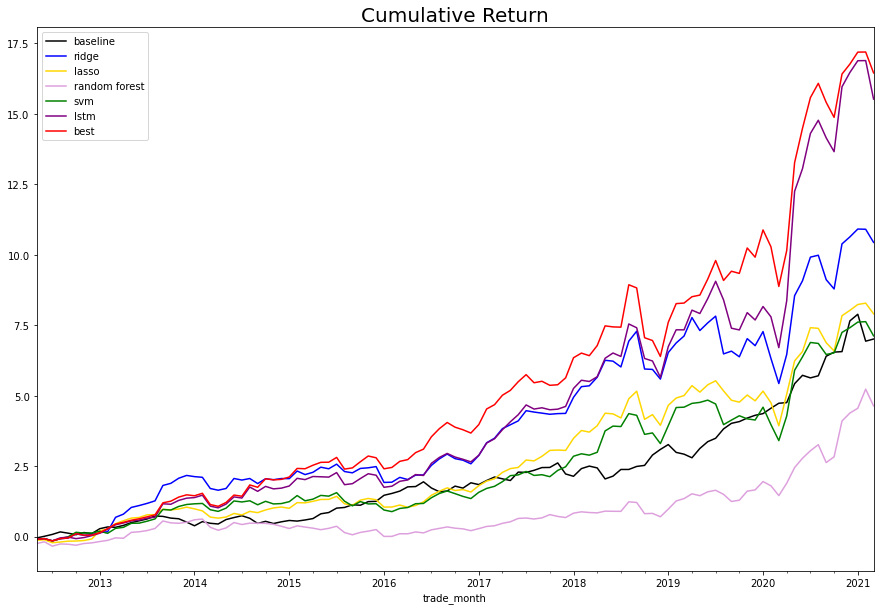

In [112]:
plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

ridge = ((df_portfolio_return_ridge+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso+1).cumprod()-1).plot(c='gold',label='lasso')
rf = ((df_portfolio_return_rf+1).cumprod()-1).plot(c='plum',label='random forest')
svm = ((df_portfolio_return_svm+1).cumprod()-1).plot(c='green',label='svm')
lstm = ((df_portfolio_return_lstm+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)

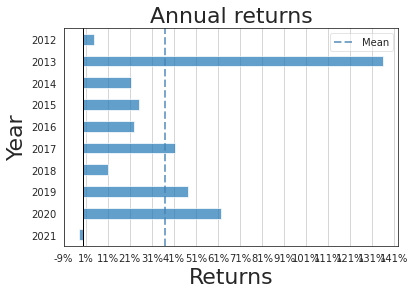

In [141]:
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def annual_return_barplot(returns,ax=None):
    if ax is None:
        ax = plt.gca()
        
    sns.set_style('white')
    ax.set_xticklabels(np.arange(0, 0.6, 0.1))
    x_axis_formatter = FuncFormatter(pf.utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    #ax.tick_params(axis='x', which='major')
    

    ann_ret_df = pd.DataFrame(
        pf.ep.aggregate_returns(
            returns,
            'yearly'))
    display
    ax.axvline(
        100 *
        ann_ret_df.values.mean(),
        color='steelblue',
        linestyle='--',
        lw=2,
        alpha=0.7)
    (100 * ann_ret_df.sort_index(ascending=False)
     ).plot(ax=ax, kind='barh', alpha=0.70)
    ax.axvline(0.0, color='black', linestyle='-', lw=1)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))
    ax.grid(axis='x')
    #ax.xaxis.xtickers.
    ax.set_ylabel('Year',fontsize=22)
    ax.set_xlabel('Returns',fontsize=22)
    ax.set_title("Annual returns",fontsize=22)
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    return ax


annual_return_barplot(df_portfolio_return_best)

# 5. Other Visualization
1. The first graph shows models' evaluation score as a function of months
2. The second and the third graph shows the best prediction for a specific ticker's ('CSCO') monthly return and the ticker's actual monthly return.

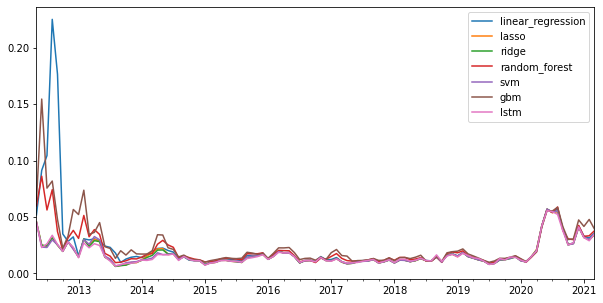

In [116]:

def show_best_model_pie(df_best_model_name):
  display(df_best_model_name)
  best_models = df_best_model_name["model_name"].value_counts()
  display(best_models)
  plt.pie(best_models.values, labels = list(best_models.index))
  plt.show()

def show_model_eval(df_predict_best, evaluation_record):
  evaluation_list = []
  for i in range(min(df_predict_best.shape[0], len(evaluation_record))):
    if(len(evaluation_record[i])<2):break
    evaluation_list.append(evaluation_record[i][1]['model_eval'].values)

  df_evaluation = pd.DataFrame(evaluation_list,columns = ['linear_regression', 'lasso','ridge','random_forest','svm','gbm', 'lstm'])
  df_evaluation.index = df_predict_best.index.values[:len(evaluation_record)]
  df_evaluation.plot(figsize=(10,5))

#show_best_model_pie(df_best_model_name) 
show_model_eval(df_predict_best, evaluation_record) 


In [117]:
def show_single_stock_accuracy(df, df_predict, unique_datetime, ticker):
  from matplotlib import pyplot
  prediction = df_predict[ticker]

  df2 = df.loc[df["ticker"]==ticker]
  df2 = df2.loc[df2["month_start"].isin(unique_datetime)]

  actual = list(df2["monthly_return"])
  pred = df_predict[ticker].dropna()
  pred = list(pred)

  months = list(df2["month_start"])
  
  pred = pd.DataFrame(index=months, columns = ["monthly_return"])
  act = pd.DataFrame(index=months, columns = ["monthly_return"])

  pred["monthly_return"] = prediction
  act["monthly_return"] = actual
  pred.plot()
  pyplot.show()
  act.plot()
  pyplot.show()

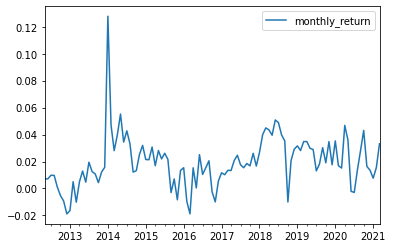

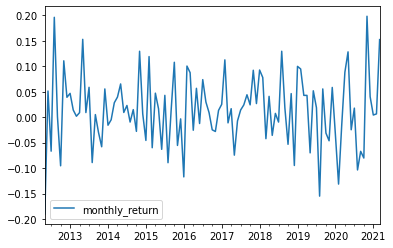

In [118]:
show_single_stock_accuracy(df, df_predict_best, unique_datetime, 'CSCO')